In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/housing.csv')

In [ ]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


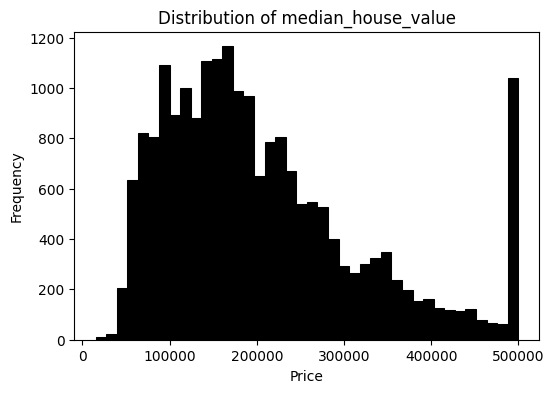

In [ ]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value , bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of median_house_value')

plt.show()

In [ ]:
df2 = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]


In [ ]:
df3 = df2[['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']]

Question 1
There's one feature with missing values. What is it?



In [ ]:
df3.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Question 2
What's the median (50% percentile) for variable 'population'?

In [ ]:
df3['population'].quantile(0.5)

1195.0

Prepare and split the dataset

In [ ]:
np.random.seed(42)

n = len(df3)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df3.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()




In [ ]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)


In [ ]:

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

Question 3

Ooption 1: fill it with 0

In [ ]:
df_train_opt1 = df_train.copy()
df_val_opt1 = df_val.copy()
df_test_opt1 = df_test.copy()

In [ ]:
df_train_opt1['total_bedrooms'].fillna(0, inplace=True)
df_val_opt1['total_bedrooms'].fillna(0, inplace=True)
df_test_opt1['total_bedrooms'].fillna(0, inplace=True)


In [ ]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [ ]:
w_0, w = train_linear_regression(df_train_opt1, y_train)

In [ ]:
y_pred_opt1 = w_0 + df_val_opt1.dot(w)

In [ ]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [ ]:
score = rmse(y_val, y_pred_opt1)
round(score, 2)

0.34

Option 2: fill with the mean

In [ ]:
df_train_opt2 = df_train.copy()
df_val_opt2 = df_val.copy()
df_test_opt2 = df_test.copy()

In [ ]:
df_val_opt2['total_bedrooms'].fillna(df_train_opt2['total_bedrooms'].mean(), inplace=True)
df_test_opt2['total_bedrooms'].fillna(df_train_opt2['total_bedrooms'].mean(), inplace=True)
df_train_opt2['total_bedrooms'].fillna(df_train_opt2['total_bedrooms'].mean(), inplace=True)

In [ ]:
w_0, w = train_linear_regression(df_train_opt2, y_train)

In [ ]:
y_pred_opt2 = w_0 + df_val_opt2.dot(w)

In [ ]:
score = rmse(y_val, y_pred_opt2)
round(score, 2)

0.34

Question 4
REGULARIZATION

In [ ]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [ ]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train_opt1, y_train, r=r)
    y_pred_train = w_0 + df_train_opt1.dot(w)
    rmse_train = rmse(y_train, y_pred_train)

    y_pred_test = w_0 + df_test_opt1.dot(w)
    rmse_test = rmse(y_test, y_pred_test)

    y_pred_val = w_0 + df_val_opt1.dot(w)
    rmse_val = rmse(y_val, y_pred_val)

    print('%5s, %.2f, %.2f, %.2f' % (r, rmse_train, rmse_test, rmse_val))

    0, 0.34, 0.33, 0.34
1e-06, 0.34, 0.33, 0.34
0.0001, 0.34, 0.33, 0.34
0.001, 0.34, 0.33, 0.34
 0.01, 0.34, 0.33, 0.34
  0.1, 0.34, 0.33, 0.34
    1, 0.34, 0.33, 0.34
    5, 0.35, 0.34, 0.35
   10, 0.35, 0.34, 0.35


Question 5

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))
What's the value of std?

In [ ]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:

n = len(df3)
valores = []

for i in seeds:
    np.random.seed(i)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df3.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    df_train['total_bedrooms'].fillna(0, inplace=True)

    w_0, w = train_linear_regression(df_train_opt1, y_train)
    y_pred_val = w_0 + df_val_opt1.dot(w)
    score = rmse(y_val, y_pred_val)
    print('%5s, %.2f'% (i, score))
    valores.append(score)


    0, 0.56
    1, 0.56
    2, 0.57
    3, 0.56
    4, 0.57
    5, 0.57
    6, 0.57
    7, 0.57
    8, 0.58
    9, 0.56


What's the value of std?

In [ ]:
desviacion = np.std(valores)
round(desviacion, 3)

0.005

Question 6

Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [ ]:
n = len(df3)

np.random.seed(9)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df3.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()


y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


x_concat = pd.concat([df_train,df_val])
y_concat = np.concatenate((y_train , y_val))

x_concat['total_bedrooms'].fillna(0, inplace=True)

df_test['total_bedrooms'].fillna(0, inplace=True)

w_0, w = train_linear_regression_reg(x_concat, y_concat, r=0.001)

y_pred_test = w_0 + df_test.dot(w)
score = rmse(y_test, y_pred_test)
score

0.33498993366147484